In this notebook we use normalized text data i.e. text which has been processed using case folding, stop words removal, etc. to train RNN, LSTM and GRU models and compare the performance of each model.

In [21]:
import numpy as np     
import pandas as pd    
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# load the dataset containing normalized text as well as the additional features obtained from notebook 1

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train_clean_add_feat.csv', index_col = False)

df_train.head()

,text,target,text_norm,stemmed_keyword,disaster_asc_coeff,length_norm,neg,neu,pos
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak,0.785714,41,0.000,1.000,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire,0.386364,36,0.286,0.714,0.0
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu,0.767241,69,0.000,1.000,0.0
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu,0.767241,49,0.000,1.000,0.0
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire,0.386364,52,0.000,1.000,0.0


In [23]:
# In this part we will compare results using the original text with minimum processing vs the normalized text 
df = df_train[['text', 'target']]

### Remove numerical values from normalized text

In [24]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [25]:
# we will fill null values for 'keyword' based on the list of present keywords that was just created
def normalize(raw_text):
    
    # remove hyperlink
    text_c1 = raw_text.split('http')[0].strip()
    
    # remove all other punctuation
    text_c2 = ''.join([ch for ch in text_c1 if ch not in string.punctuation])
    
    # remove username
    text_c3 = [word for word in text_c2.split() if '@' not in word]
    
    # remove numbers
    text_c4 = [word for word in text_c3 if not word.isnumeric()]
    
    # remove stopwords
    text_c5 = [word for word in text_c4 if word not in stopwords.words('english')]
    
    # stemming
    stemmer = PorterStemmer()
    text_c6 = ' '.join([stemmer.stem(word) for word in text_c5])
    
    # convert text to lowercase
    text_c7 = text_c6.lower()
    
    return text_c7

In [26]:
df['final_text'] = df['text'].apply(normalize)

C:\Users\shisk\AppData\Local\Temp\ipykernel_19068\3824082999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_text'] = df['text'].apply(normalize)


In [27]:
df.head()

,text,target,final_text
0,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic no ev...
3,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo rubi alaska smoke wildfir ...


## Training with text data without stopwords
For this text data, stop words, symbols, urls and punctuations have been removed. In addition, the words have also been stemmed. This means that the vocabulariy will be smaller; however, any contextual information provided by stop words will be lost.

#### Prepare text data for embedding

In [28]:
# use tokenizer and padding to prepare data for embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
tokenizer = Tokenizer()

In [30]:
# fit text to data
tokenizer.fit_on_texts(df['final_text'])

In [31]:
# tokenize text data
df_tokens = tokenizer.texts_to_sequences(df['final_text'])
df_tokens[0]

[614, 3670, 493, 302, 99, 1521, 3671, 22]

In [32]:
# get max length to pad sequences and abd vocab size
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAX_LENGTH = max([len(text.split()) for text in df_norm['final_text']])
EMBEDDING_DIM = 200
print(f'Vocab size: {VOCAB_SIZE}')
print(f'Max sequence length: {MAX_LENGTH}')
print(f'Embedding dim: {EMBEDDING_DIM}')

Vocab size: 13963
Max sequence length: 23
Embedding dim: 200


In [33]:
# add padding
df_pad = pad_sequences(df_tokens, maxlen = MAX_LENGTH, padding = 'post')
df_pad[0]

array([ 614, 3670,  493,  302,   99, 1521, 3671,   22,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [34]:
print(type(df_pad))
print(df_pad.shape)

<class 'numpy.ndarray'>
(7593, 23)


### Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X = df_pad
y = df['target']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [38]:
X_train[0]

array([3705, 3706, 2125,   57,  252, 5361,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

### Simple RNN model
Since the goal is to train a binary classification model, the RNN architecture will be many-to-one.

In [39]:
# basic architecture from tensorflow classiication with RNN documentation
import tensorflow as tf

In [40]:
model = tf.keras.Sequential()

The embedding layer converts the numeric representation of a word which would be a vector the length of the vocabularity if it were a dummy variable(with all entried 0's ecxept 1) and converts it to a vector of fixed length with all entries as floating point values. Therefore, instead of having a large sparse matrix for a sentence, we will have a smaller dense matrix as input. <br>
input_dim : Size of the vocabulary <br>
output_dim : Length of the embedded vector for each word <br>
input_length : Maximum length of a sequence

In [41]:
model.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model.add(tf.keras.layers.SimpleRNN(EMBEDDING_DIM, dropout = 0.3))
model.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 200)           2792600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 200)               80200     
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                12864     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [43]:
# compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [44]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 7s 43ms/step - loss: 0.6949 - accuracy: 0.4986 - val_loss: 0.6872 - val_accuracy: 0.5676
Epoch 2/7
120/120 [==============================] - 5s 39ms/step - loss: 0.6763 - accuracy: 0.5948 - val_loss: 0.6667 - val_accuracy: 0.5786
Epoch 3/7
120/120 [==============================] - 5s 39ms/step - loss: 0.5931 - accuracy: 0.7195 - val_loss: 0.5586 - val_accuracy: 0.7264
Epoch 4/7
120/120 [==============================] - 5s 40ms/step - loss: 0.4141 - accuracy: 0.8359 - val_loss: 0.5394 - val_accuracy: 0.7563
Epoch 5/7
120/120 [==============================] - 5s 39ms/step - loss: 0.2897 - accuracy: 0.8970 - val_loss: 0.5968 - val_accuracy: 0.7484
Epoch 6/7
120/120 [==============================] - 5s 43ms/step - loss: 0.2037 - accuracy: 0.9318 - val_loss: 0.6203 - val_accuracy: 0.7524
Epoch 7/7
120/120 [==============================] - 6s 50ms/step - loss: 0.1518 - accuracy: 0.9465 - val_loss: 0.6940 - val_accuracy: 0.7288


In [45]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7220636025071144)

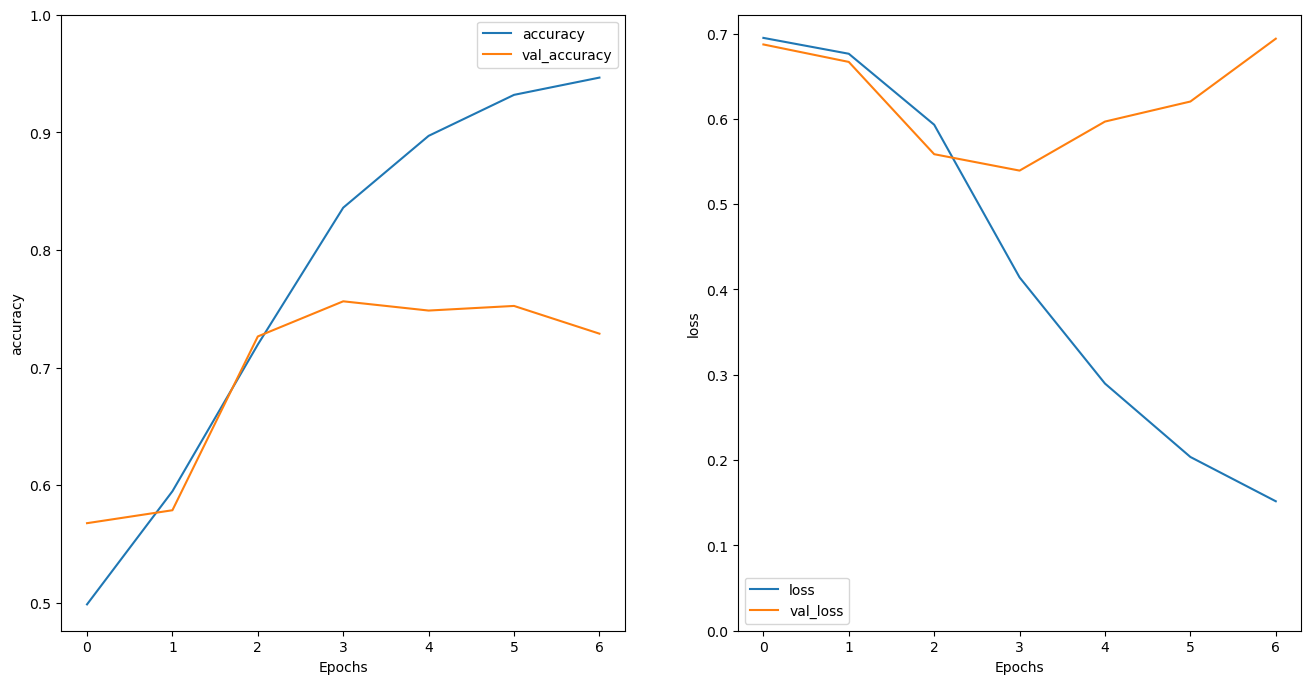

In [46]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 7ms/step - loss: 0.6793 - accuracy: 0.7454


In [48]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.6792845129966736
Test Accuracy: 0.7454110383987427


### LSTM

In [49]:
model_lstm = tf.keras.Sequential()

In [50]:
model_lstm.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_lstm.add(tf.keras.layers.LSTM(EMBEDDING_DIM, dropout = 0.3))
model_lstm.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [51]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 200)           2792600   
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                12864     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [52]:
# compile model
model_lstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [53]:
history = model_lstm.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 16s 82ms/step - loss: 0.6909 - accuracy: 0.5623 - val_loss: 0.6873 - val_accuracy: 0.5605
Epoch 2/7
120/120 [==============================] - 8s 68ms/step - loss: 0.6532 - accuracy: 0.6008 - val_loss: 0.6068 - val_accuracy: 0.7516
Epoch 3/7
120/120 [==============================] - 8s 71ms/step - loss: 0.4764 - accuracy: 0.8262 - val_loss: 0.4988 - val_accuracy: 0.7642
Epoch 4/7
120/120 [==============================] - 10s 84ms/step - loss: 0.3107 - accuracy: 0.8789 - val_loss: 0.5084 - val_accuracy: 0.7712
Epoch 5/7
120/120 [==============================] - 9s 78ms/step - loss: 0.2207 - accuracy: 0.9214 - val_loss: 0.6162 - val_accuracy: 0.7807
Epoch 6/7
120/120 [==============================] - 9s 72ms/step - loss: 0.1641 - accuracy: 0.9431 - val_loss: 0.6588 - val_accuracy: 0.7531
Epoch 7/7
120/120 [==============================] - 8s 70ms/step - loss: 0.1360 - accuracy: 0.9523 - val_loss: 0.7512 - val_accuracy: 0.7594


In [54]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7819551222026349)

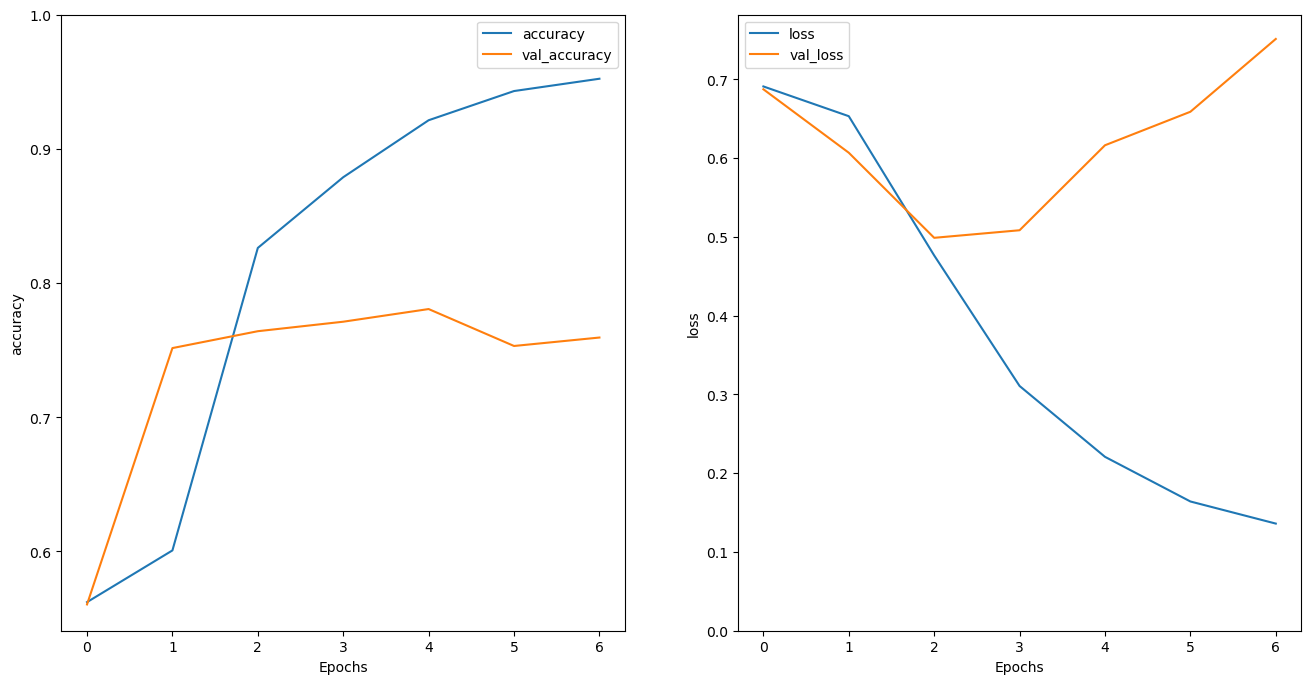

In [55]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [56]:
test_loss, test_acc = model_lstm.evaluate(X_test, y_test)

79/79 [==============================] - 1s 16ms/step - loss: 0.7839 - accuracy: 0.7566


In [57]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.7839292883872986
Test Accuracy: 0.7565842270851135


### Bidirectional LSTM

In [58]:
model_blstm = tf.keras.Sequential()

In [59]:
model_blstm.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_blstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM, dropout = 0.3)))
model_blstm.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_blstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_blstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_blstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_blstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_blstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [60]:
model_blstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 200)           2792600   
                                                                 
 bidirectional (Bidirectiona  (None, 400)              641600    
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 200)               80200     
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                12864     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [61]:
# compile model
model_blstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [62]:
history = model_blstm.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 29s 139ms/step - loss: 0.6888 - accuracy: 0.5714 - val_loss: 0.6831 - val_accuracy: 0.5605
Epoch 2/7
120/120 [==============================] - 13s 109ms/step - loss: 0.6379 - accuracy: 0.6147 - val_loss: 0.5773 - val_accuracy: 0.7767
Epoch 3/7
120/120 [==============================] - 18s 150ms/step - loss: 0.4195 - accuracy: 0.8456 - val_loss: 0.4922 - val_accuracy: 0.7885
Epoch 4/7
120/120 [==============================] - 15s 129ms/step - loss: 0.2594 - accuracy: 0.9043 - val_loss: 0.5471 - val_accuracy: 0.7759
Epoch 5/7
120/120 [==============================] - 12s 103ms/step - loss: 0.1724 - accuracy: 0.9410 - val_loss: 0.6508 - val_accuracy: 0.7681
Epoch 6/7
120/120 [==============================] - 12s 100ms/step - loss: 0.1323 - accuracy: 0.9560 - val_loss: 0.7406 - val_accuracy: 0.7649
Epoch 7/7
120/120 [==============================] - 12s 100ms/step - loss: 0.1045 - accuracy: 0.9644 - val_loss: 0.8038 - val_accuracy:

In [63]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.8387322336435318)

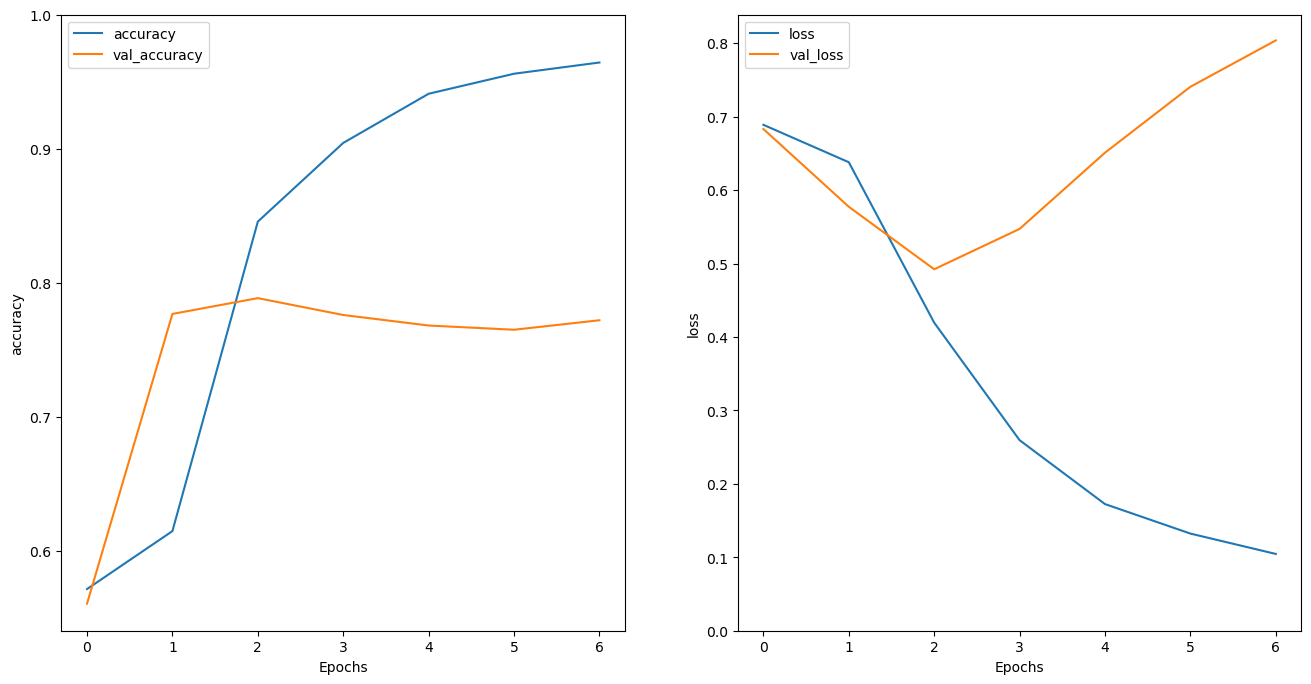

In [64]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [65]:
test_loss, test_acc = model_blstm.evaluate(X_test, y_test)

79/79 [==============================] - 2s 21ms/step - loss: 0.8647 - accuracy: 0.7638


In [66]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.8647264838218689
Test Accuracy: 0.7637669444084167


### GRU

In [67]:
model_gru = tf.keras.Sequential()

In [68]:
model_gru.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_gru.add(tf.keras.layers.GRU(EMBEDDING_DIM, dropout = 0.3))
model_gru.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(rate = 0.25))
model_gru.add(tf.keras.layers.Dense(64, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(rate = 0.25))
model_gru.add(tf.keras.layers.Dense(32, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [69]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 200)           2792600   
                                                                 
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense_12 (Dense)            (None, 200)               40200     
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                12864     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [70]:
# compile model
model_gru.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [71]:
history = model_gru.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 13s 72ms/step - loss: 0.6878 - accuracy: 0.5722 - val_loss: 0.6836 - val_accuracy: 0.5605
Epoch 2/7
120/120 [==============================] - 7s 58ms/step - loss: 0.6635 - accuracy: 0.5743 - val_loss: 0.6253 - val_accuracy: 0.5613
Epoch 3/7
120/120 [==============================] - 7s 59ms/step - loss: 0.5093 - accuracy: 0.7866 - val_loss: 0.4866 - val_accuracy: 0.7767
Epoch 4/7
120/120 [==============================] - 7s 59ms/step - loss: 0.3002 - accuracy: 0.8862 - val_loss: 0.4906 - val_accuracy: 0.7877
Epoch 5/7
120/120 [==============================] - 7s 59ms/step - loss: 0.2033 - accuracy: 0.9256 - val_loss: 0.5611 - val_accuracy: 0.7830
Epoch 6/7
120/120 [==============================] - 7s 58ms/step - loss: 0.1504 - accuracy: 0.9478 - val_loss: 0.6334 - val_accuracy: 0.7657
Epoch 7/7
120/120 [==============================] - 7s 59ms/step - loss: 0.1204 - accuracy: 0.9599 - val_loss: 0.6724 - val_accuracy: 0.7720


In [72]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.716205732524395)

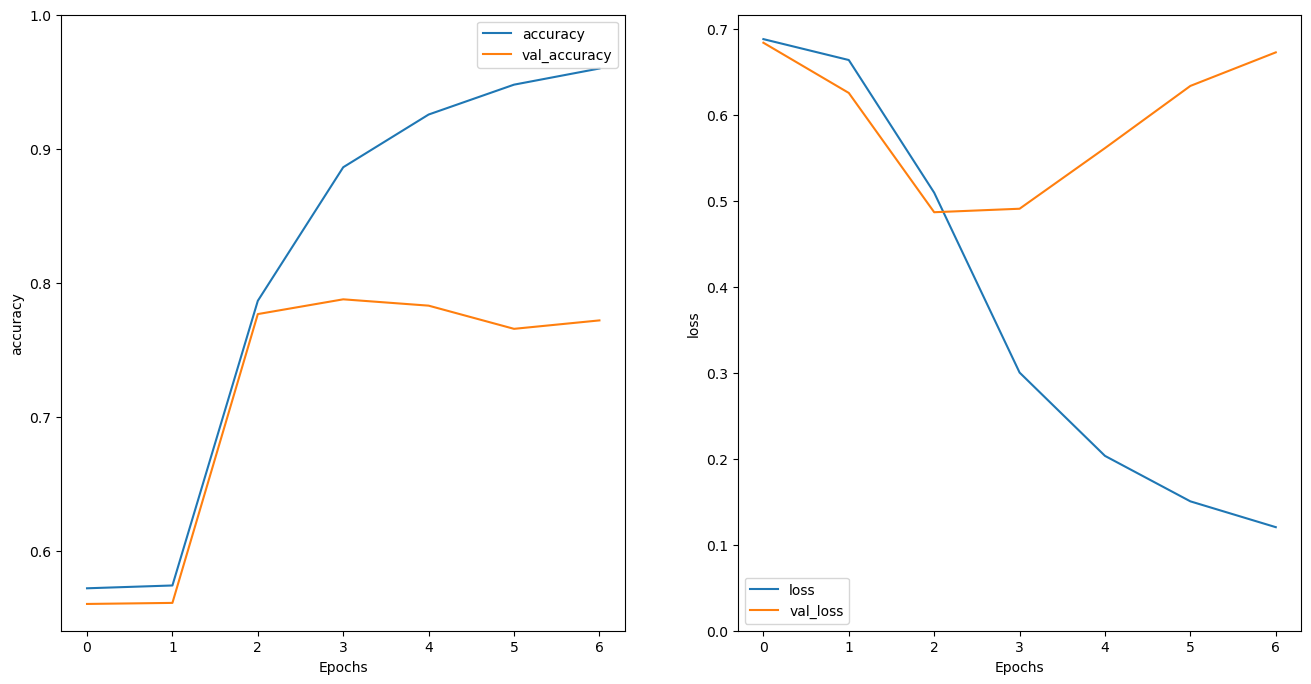

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [74]:
test_loss, test_acc = model_gru.evaluate(X_test, y_test)

79/79 [==============================] - 1s 13ms/step - loss: 0.7371 - accuracy: 0.7618


In [75]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.7371086478233337
Test Accuracy: 0.7617717385292053


### Conclusion for Test Accuracy
SimpleRNN: 0.7270<br>
LSTM: 0.7797<br>
Bidirectional LSTM: 0.7434<br>
GRU: 0.756